
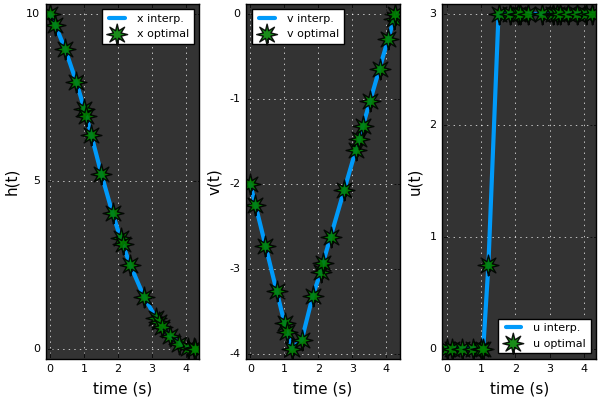

In [9]:
using NLOptControl, JuMP, Ipopt, Parameters, Plots
pyplot()

##################################
# Define NLOptControl problem
##################################
n = NLOpt();
# Moon Lander Problem @ http://www.gpops2.com/Examples/MoonLander.html
const g = 1.62519; # m/s^2
function MoonLander{T<:Any}(mdl::JuMP.Model,n::NLOpt,x::Array{T,2},u::Array{T,2}) # dynamic constraint equations
  if n.integrationMethod==:tm; L=size(x)[1]; else L=size(x)[1]-1; end
  dx = Array(Any,L,n.numStates)
  dx[:,1] =  @NLexpression(mdl, [j=1:L], x[j,2] );
  dx[:,2] =  @NLexpression(mdl, [j=1:L], u[j,1] - g);
  return dx
end

n = define(n,stateEquations=MoonLander,numStates=2,numControls=1,X0=[10.,-2],XF=[0.,0.],XL=[-Inf,-Inf],XU=[Inf,Inf],CL=[0.],CU=[3.])
#n = configure(n,Ni=2,Nck=[15,10];(:integrationMethod => :ps),(:integrationScheme => :lgrExplicit),(:finalTimeDV => false),(:tf => 4.0))
#n = configure(n,N=10;(:integrationMethod => :tm),(:integrationScheme => :bkwEuler),(:finalTimeDV => false),(:tf => 4.0))
#n = configure(n,N=10;(:integrationMethod => :tm),(:integrationScheme => :trapezoidal),(:finalTimeDV => false),(:tf => 4.0))

# with time
n = configure(n,Ni=4,Nck=[5,5,4,6];(:integrationMethod => :ps),(:integrationScheme => :lgrExplicit),(:finalTimeDV =>true))
#n = configure(n,N=30;(:integrationMethod => :tm),(:integrationScheme => :bkwEuler),(:finalTimeDV => true))
#n = configure(n,N=30;(:integrationMethod => :tm),(:integrationScheme => :trapezoidal),(:finalTimeDV => true))

##################################
# Define JuMP problem
##################################
mdl = Model(solver = IpoptSolver(print_level=1,max_iter=500));
n,r = OCPdef(mdl,n) 
obj = integrate(mdl,n,r.u[:,1];C=1.0,(:variable=>:control),(:integrand=>:default))
@NLobjective(mdl, Min, obj)
result = solve(mdl)
##################################
# Post Processing
##################################
r=postProcess(n,r); s=Settings();

p1=plot(r.t_st,r.X[:,1], label = "x interp.",w=s.lw2)
scatter!(r.t_st,r.X[:,1], label = "x optimal",marker = (:star8, 15, 0.9, :green))
ylabel!("h(t)")
xlabel!("time (s)")

p2=plot(r.t_st,r.X[:,2], label = "v interp.",w=s.lw2)
scatter!(r.t_st,r.X[:,2], label = "v optimal",marker = (:star8, 15, 0.9, :green))
ylabel!("v(t)")
xlabel!("time (s)")

p3=plot(r.t_ctr,r.U[:,1], label = "u interp.",w=s.lw2)
scatter!(r.t_ctr,r.U[:,1], label = "u optimal",marker = (:star8, 15, 0.9, :green))
ylabel!("u(t)")
xlabel!("time (s)")

plot(p1,p2,p3,layout=(1,3),background_color_subplot=RGB(0.2,0.2,0.2), background_color_legend=RGB(1,1,1))
plot!(foreground_color_grid=RGB(1,1,1))


In [10]:
# resize to save
plot!(titlefont=font(14),guidefont=font(14),tickfont=font(12),legendfont=font(12))
plot!(leg=:best)
plot!(size=(700,850))
savefig("ex1_p.png")